### How to compile to C-Code with sympy

The permatracks project deals with a large inverse problem.
We want to compute the position and direction of a magnet from the outputs of several sensors.
Each output is the magnetic flux density in 3 directions.
With the dipol model we can calculate the magnetic flux density from the position and direction of a magnet.
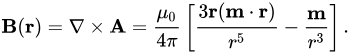

With an optimizer, we can compute the inverse problem, but defining all the expressions for multiple sensors by hand in C becomes error-prone and not really customizable.
Optimizers like Levenberg-Marquardt also use the Jacobian, which is even more error-prone.
Sympy allows you to define complex mathematical expressions and functions.
It also has a module for compiling to C code.

In [1]:
import sympy as sp
import sys

### Create variables and build functions:

In [2]:
x, y, z = sp.symbols('x, y, z', real=True)

fun = x + y + z
print("fun:", fun)

fun: x + y + z


### Substitute variables with values:

In [3]:
fun2 = fun.subs(z, 3)
print("fun2:", fun2)

fun2: x + y + 3


### Create lamda functions form functions:

In [4]:
lam_fun = sp.utilities.lambdify([x, y, z], fun)
lam_fun2 = sp.utilities.lambdify([x, y], fun2)

result = lam_fun(1, 2, 3)
print("lam_fun:", result)
result = lam_fun2(1, 2)
print("lam_fun2:", result)

lam_fun: 6
lam_fun2: 6


### Compile sympy functions to C:

In [5]:
from sympy.utilities.codegen import codegen

out = sp.symbols('out', real=True)

eq = sp.Eq(out, fun)
eq2 = sp.Eq(out, fun2)
[(c_name, c_code), (h_name, h_code)] = codegen([("fun", eq), ("fun2", eq2)], language="C",
                                               project="sympy_compile_example", standard="C11", prefix="fun_fun2",
                                               argument_sequence=[out, x, y, z])

print("Generated files:")

print("-", h_name)
print(h_code)

print("-", c_name)
print(c_code)

Generated files:
- fun_fun2.h
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                This file is part of 'sympy_compile_example'                *
 ******************************************************************************/


#ifndef SYMPY_COMPILE_EXAMPLE__FUN_FUN2__H
#define SYMPY_COMPILE_EXAMPLE__FUN_FUN2__H

void fun(double *out, double x, double y, double z);
void fun2(double *out, double x, double y, double z);

#endif


- fun_fun2.c
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                            

### Create vector-valued functions:

In [6]:
fun3 = sp.Matrix([x ** 2, x + y, x + y + sp.cos(z)])
print("fun3:")
sp.pprint(fun3)

fun3:
⎡       2      ⎤
⎢      x       ⎥
⎢              ⎥
⎢    x + y     ⎥
⎢              ⎥
⎣x + y + cos(z)⎦


### Compute jacobian of vector-valued functions:

In [7]:
fun3_jacobian = fun3.jacobian([x, y, z])
print("fun3_jacobian:")
sp.pprint(fun3_jacobian)

fun3_jacobian:
⎡2⋅x  0     0   ⎤
⎢               ⎥
⎢ 1   1     0   ⎥
⎢               ⎥
⎣ 1   1  -sin(z)⎦


### Compile vector-valued functions to C:

In [8]:
out = sp.MatrixSymbol('out', *fun3.shape)

eq = sp.Eq(out, fun3)
[(c_name, c_code), (h_name, h_code)] = codegen([("fun3", eq)], language="C",
                                               project="sympy_compile_example", standard="C11", prefix="fun3",
                                               argument_sequence=[out, x, y, z])

print("Generated files:")

print("-", h_name)
print(h_code)

print("-", c_name)
print(c_code)

Generated files:
- fun3.h
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                This file is part of 'sympy_compile_example'                *
 ******************************************************************************/


#ifndef SYMPY_COMPILE_EXAMPLE__FUN3__H
#define SYMPY_COMPILE_EXAMPLE__FUN3__H

void fun3(double *out, double x, double y, double z);

#endif


- fun3.c
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See

### Compile matrix-valued functions to C:

In [9]:
out = sp.MatrixSymbol('out', *fun3_jacobian.shape)

eq = sp.Eq(out, fun3_jacobian)
[(c_name, c_code), (h_name, h_code)] = codegen([("fun", eq)], language="C",
                                               project="sympy_compile_example", standard="C11", prefix="fun3",
                                               argument_sequence=[out, x, y, z])

print("Generated files:")

print("-", h_name)
print(h_code)

print("-", c_name)
print(c_code)

Generated files:
- fun3.h
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                This file is part of 'sympy_compile_example'                *
 ******************************************************************************/


#ifndef SYMPY_COMPILE_EXAMPLE__FUN3__H
#define SYMPY_COMPILE_EXAMPLE__FUN3__H

void fun(double *out, double x, double y, double z);

#endif


- fun3.c
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See 

### Optimization Problem for one permanent magnet and 16 sensors:

In [10]:
import os
permatracks_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
import sys
sys.path.append(permatracks_path)

from optimization.scripts.models import dipol_model
from data_collection.scripts.collect_medability_sensor_array_data import get_sensor_position_values

sensor_position_values = get_sensor_position_values()
model, symbols = dipol_model(sensor_position_values)


F = sp.Matrix(model)
J = F.jacobian([symbols['x1'], symbols['y1'], symbols['z1'], symbols['theta1'], symbols['phi1'], symbols['Gx'],
                symbols['Gy'], symbols['Gz']])

B = sp.MatrixSymbol('B', *F.shape)
BB = sp.MatrixSymbol('BB', *J.shape)

eq = sp.Eq(B, F)
eq2 = sp.Eq(BB, J)

[(c_name, c_code), (h_name, h_code)] = codegen([("dipol_model", eq), ("dipol_model_jacobian", eq2)], language="C",
                                               project="SensorArrayDipolModel",
                                               standard="C11", prefix="sensor_array_dipol_model",
                                               argument_sequence=[B, BB, symbols['m1'], symbols['x1'],
                                                                  symbols['y1'],
                                                                  symbols['z1'], symbols['theta1'],
                                                                  symbols['phi1'], symbols['Gx'], symbols['Gy'],
                                                                  symbols['Gz']])

print("Generated files:")

print("-", h_name)
print(h_code)

print("-", c_name)
print(c_code)

Generated files:
- sensor_array_dipol_model.h
/******************************************************************************
 *                       Code generated with SymPy 1.12                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                This file is part of 'SensorArrayDipolModel'                *
 ******************************************************************************/


#ifndef SENSORARRAYDIPOLMODEL__SENSOR_ARRAY_DIPOL_MODEL__H
#define SENSORARRAYDIPOLMODEL__SENSOR_ARRAY_DIPOL_MODEL__H

void dipol_model(double *B, double *BB, double m1, double x1, double y1, double z1, double theta1, double phi1, double Gx, double Gy, double Gz);
void dipol_model_jacobian(double *B, double *BB, double m1, double x1, double y1, double z1, double theta1, double phi1, doubl